In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
from collections import defaultdict
from collections import Counter

In [2]:
import psutil
psutil.cpu_count()
p = psutil.Process()
p.cpu_affinity([0,1,2,3,4,5,6,7,8])

In [3]:
os.chdir(r'H:\all\RL_Shrinkage_2024')
from helpers import helper_functions as hf

In [4]:
import glob

path = r'H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\transformed_qis_eigenvalues'
extension = 'csv'
os.chdir(path)
filenames = glob.glob('*.{}'.format(extension))
print(filenames)

['cov2para_evs_df.csv', 'cov2para_fixed04_evs_df.csv', 'cov2para_plus02_evs_df.csv', 'qis_evs_df.csv', 'qis_evs_exp_05.csv', 'qis_evs_exp_2.csv', 'sample_evs_df.csv']


In [5]:
def get_ev_intensities(evs, sample_evs):
    intensities = evs.copy()
    intensities.iloc[:, -251:] = evs.iloc[:, -251:].values / sample_evs.iloc[:, -251:].values
    return intensities

def plot_last_x_intensities_across_time(intensities_dfs, modelnames, num_evs, return_df=False):
    if len(modelnames) > 1:
        dfs_list = [intensities_dfs[M].iloc[:, -num_evs:].mean(axis=1) for M in modelnames]
        df = pd.concat(dfs_list, axis=1)
        df.columns = modelnames
    else:
        df = intensities_dfs[modelnames[0]].iloc[:, -num_evs:].mean(axis=1)
        df.name = modelnames[0]
    fig = px.line(
        df,
        title = f"Plot of Average EV(Model) / EV(Sample) Across Time",
         labels={'value':f'Mean of EV(Model) / EV(Sample)'},
        height=700
    )
    fig.show()

def plot_last_x_intensities_across_assets(intensities_dfs, modelnames, num_evs, return_df=False):
    if len(modelnames) > 1:
        dfs_list = [intensities_dfs[M].iloc[:, -num_evs:].mean() for M in modelnames]
        df = pd.concat(dfs_list, axis=1)
        df.columns = modelnames
    else:
        df = intensities_dfs[modelnames[0]].iloc[:, -num_evs:].mean()
        df.name = modelnames[0]
        
    fig = px.line(
        df,
        title = f"Plot of Average EV(Model) / EV(Sample) Across Assets",
         labels={'value':f'Mean of EV(Model) / EV(Sample)', 'index': "Eigenvalue"},
        height=700
    )
    fig.show()


def plot_last_x_eigenvalues_across_time(eigenvalues_dfs, modelnames, ev_range, return_df=False):
    if len(modelnames) > 1:
        dfs_list = [eigenvalues_dfs[M].iloc[:, ev_range[0]:ev_range[1]].mean(axis=1) for M in modelnames]
        df = pd.concat(dfs_list, axis=1)
        df.columns = modelnames
    else:
        df = eigenvalues_dfs[modelnames[0]].iloc[:, ev_range[0]:ev_range[1]].mean(axis=1)
        df.name = modelnames[0]
    fig = px.line(
        df,
        title = f"Plot of Average EV(Model) Across Time",
         labels={'value':f'Mean of EV(Model) '},
        height=700
    )
    fig.show()

def plot_last_x_eigenvalues_across_assets(eigenvalues_dfs, modelnames, ev_range, return_df=False):
    if len(modelnames) > 1:
        dfs_list = [eigenvalues_dfs[M].iloc[:, ev_range[0]:ev_range[1]].mean() for M in modelnames]
        df = pd.concat(dfs_list, axis=1)
        df.columns = modelnames
    else:
        df = eigenvalues_dfs[modelnames[0]].iloc[:, ev_range[0]:ev_range[1]].mean()
        df.name = modelnames[0]
        
    fig = px.line(
        df,
        title = f"Plot of Average EV(Model) Across Assets",
         labels={'value':f'Mean of EV(Model)', 'index': "Eigenvalue"},
        height=700
    )
    fig.show()


def get_rawres(eigenvalue_dict, modelnames: list):
    tmp_res = defaultdict(list)
    tmp_rawres = defaultdict(list)
    for idx in range(0, permnos.shape[0]):
        try:
            past_ret_mat = rets_full[permnos.iloc[idx]].iloc[idx + add_idx - 21 * 12 * 1: idx + add_idx, :]
            past_ret_mat = past_ret_mat.sub(past_ret_mat.mean())
            past_ret_mat = past_ret_mat.fillna(0)
            fut_ret_mat = rets_full[permnos.iloc[idx]].iloc[idx + add_idx: idx + add_idx + 21, :]
        except:
            print("Some Error..")
            
        N, p = past_ret_mat.shape
        sample = pd.DataFrame(np.matmul(past_ret_mat.T.to_numpy(), past_ret_mat.to_numpy())) / (N - 1)
        lambda1, u = np.linalg.eigh(sample)
        lambda1 = lambda1.real.clip(min=0)
        dfu = pd.DataFrame(u,columns=lambda1)
        dfu.sort_index(axis=1,inplace = True)
        temp1 = dfu.to_numpy()
        temp3 = dfu.T.to_numpy().conjugate()

        for cur_modelname in modelnames:
            qis = eigenvalue_dict[cur_modelname].iloc[idx, :]
            temp2 = np.diag(qis)
            sigmahat = pd.DataFrame(np.matmul(np.matmul(temp1, temp2), temp3))
            try:
                weights = hf.calc_global_min_variance_pf(sigmahat)
            except:
                print("Some Other Error..")
            # store results
            tmp_res[cur_modelname].append(np.std(fut_ret_mat @ weights, ddof=1) * np.sqrt(252) * 100)
            if idx % 21 == 0:
                tmp_rawres[cur_modelname] += list(fut_ret_mat @ weights)

    return tmp_rawres, tmp_res
    

In [6]:
def get_new_eigenvalues_v2(qis_eigenvalues, sample_eigenvalues, intensity_of_intensity):
    intensity = qis_eigenvalues.copy()
    intensity.iloc[: , -251:] = qis_eigenvalues.iloc[: , -251:] / sample_eigenvalues.iloc[: , -251:]
    intensity_delta = intensity - 1
    intensity_delta_new = intensity_delta * intensity_of_intensity
    intensity_new = intensity_delta_new + 1
    qis_evs_new = intensity_new * sample_eigenvalues
    qis_evs_new.iloc[: , 0:250] = intensity_of_intensity * qis_eigenvalues.iloc[: , 0:250]
    return qis_evs_new

In [7]:
# LOAD EIGENVALUES
model_names = ["cov2para", "qis",  "sample"]
evs_dfs = {}
evs_dfs["cov2para"] =  pd.read_csv('cov2para_evs_df.csv', index_col=0)
evs_dfs["qis"] = pd.read_csv('qis_evs_df.csv', index_col=0)
evs_dfs["sample"] = pd.read_csv('sample_evs_df.csv', index_col=0)

base_folder_path = r'H:\\all\\RL_Shrinkage_2024'
pf_size = 500
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\permnos_1Y_p{pf_size}.pickle")

intensities_dfs = {}
for k, v in evs_dfs.items():
    v.index = pd.to_datetime(permnos.index, format="%Y%m%d")
    intensities_dfs[k] = get_ev_intensities(v, evs_dfs["sample"])

### Neue Idee: Eine Faktor auf dem QIS/SAMPLE Eigenwert-Quotient. 

Now let's try out the new idea: the intensity (lambda_qis / lambda_sample) and subtract 1 from it (because 1 would be lambda_qis = lambda_sample).
Then on this we apply our alpha ("intensity of intensity?") and then recalculate our new qis eigenvalues

- auch nicht ganz sauber, da eigentlich die ersten 249 intensities auch nicht wirklich dasselbe sind wie die restlichen 251 (da die ersten 249 sample eigenvalues 0 sind.)

Ganz einfach gesagt, macht diese Methode (zumindest für die grössten 251 eigenvalues// die non-null eigenvalues), dass die neuen QIS eigenvalues entweder **näher** (bei intensity of intensity unter 1) an den sample eigenvalues sind oder **weiter weg** (bei intensity of intensity > 1). Es ist auch eine intensity of intensity von 1 möglich, wo die neuen qis eigenwerte den alten qis eigenwerten entsprechen.
QIS Eigenwerte, die weiter weg sind von ihren zugehörigen Sample Eigenwerten, werden bei dieser Methode stärker verändert.

In [38]:
intensity_of_intensitiy_list = np.arange(0.5, 2.01, 0.05).round(2)

In [9]:
qis_evs_new = {}
intensities_new = {}
for intensity_of_intensity in intensity_of_intensitiy_list:
    qis_evs_new[intensity_of_intensity] = get_new_eigenvalues_v2(evs_dfs["qis"], evs_dfs["sample"], intensity_of_intensity)
    intensity = qis_evs_new[intensity_of_intensity].copy()
    intensity.iloc[: , -251:] = qis_evs_new[intensity_of_intensity].iloc[: , -251:] / evs_dfs["sample"].iloc[: , -251:]
    intensities_new[intensity_of_intensity] = intensity.copy()

#### Load return data

In [10]:
import pickle

base_folder_path = r'H:\\all\\RL_Shrinkage_2024'
# IMPORT SHRK DATASETS
pf_size = 500
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\permnos_1Y_p{pf_size}.pickle")
rets_full = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\returns_full_1Y_p{pf_size}.pickle")

fixed_shrk_name = 'cov2Para'
opt_shrk_name = 'cov2Para'
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_cov2Para_p{pf_size}.pickle", 'rb') as f:
    fixed_shrk_data = pickle.load(f)
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\cov2Para_factor-1.0_p{pf_size}.pickle", 'rb') as f:
    optimal_shrk_data = pickle.load(f)

# get all the validation indices
len_train = 5040
end_date = fixed_shrk_data.shape[0]
# temp here
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
reb_date_1 = permnos.index[0]
add_idx = np.where(rets_full.index == reb_date_1)[0][0]

#### Get the Training data for the new intensity of intensities

In [11]:
tmp_rawres, tmp_res =  get_rawres(qis_evs_new, modelnames = intensity_of_intensitiy_list)

In [24]:
all_res = pd.DataFrame(tmp_res.copy())
all_rawres = pd.DataFrame(tmp_rawres.copy())

In [32]:
allres_min_idxes_full = all_res.idxmin(axis=1)[: -21].values
allres_min_idxes_full = np.insert(allres_min_idxes_full, 0, np.repeat(["1.0"], 21))

# for sanity check: BIASED version should generally be better than
# non biased version as it is literally the minimum over the future 21 days
# so using it as a signal should outperform
allres_min_idxes_BIASED = all_res.idxmin(axis=1).values
allres_min_idxes_BIASED = allres_min_idxes_BIASED


# simple argmin rule, with full allres_min, should be same results as above
allres_min_idxes_full_v2 = allres_min_idxes_full[list(range(0, allres_min_idxes_full.shape[0], 21))]
allres_min_idxes_full_v2 = np.repeat(allres_min_idxes_full_v2, 21)
res_simple_argmin_rule = np.diag(all_rawres.loc[:, allres_min_idxes_full_v2])[5040:]


# simple argmin rule, biased (as a sanity check)
allres_min_idxes_BIASED_v2 = allres_min_idxes_BIASED[list(range(0, allres_min_idxes_BIASED.shape[0], 21))]
allres_min_idxes_BIASED_v2 = np.repeat(allres_min_idxes_BIASED_v2, 21)
res_simple_argmin_rule_biased = np.diag(all_rawres.loc[:, allres_min_idxes_BIASED_v2])[5040:]

res_actual_argmin = []
for i in range(5313//21):
    tmp_data = all_rawres.iloc[5040 + 21*i: 5040 + 21*(i+1)]
    curmin_idx = tmp_data.std().idxmin()
    curmin = tmp_data.loc[:, curmin_idx]
    res_actual_argmin += curmin.tolist()
# np.std(res_actual_argmin) * np.sqrt(252) * 100  --> 10.375

res_actual_argmin_nonbiased = []
for i in range(5313//21):
    idx_min_data = all_rawres.iloc[5040 - 21 + 21*i: 5040 - 21 + 21*(i+1)]
    curmin_idx = idx_min_data.std().idxmin()
    tmp_data = all_rawres.iloc[5040 + 21*i: 5040 + 21*(i+1)]
    curmin = tmp_data.loc[:, curmin_idx]
    res_actual_argmin_nonbiased += curmin.tolist()
#np.std(res_actual_argmin_nonbiased) * np.sqrt(252) * 100  --> 10.65

#min_idxes = fixed_shrk_data.iloc[:, 3:].idxmin(axis=1)
#opt_vals = np.diag(fixed_shrk_data.iloc[:, 3:].loc[:, min_idxes])

# get all the validation indices
len_train = 5040
end_date = fixed_shrk_data.shape[0]
# temp here
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
reb_date_1 = permnos.index[0]
add_idx = np.where(rets_full.index == reb_date_1)[0][0]

### Training and Evaluation

In [36]:
# change path
os.chdir(r'H:\all\RL_Shrinkage_2024')
from ONE_YR.NonLinear_Shrinkage import regression_evaluation_funcs as re_hf

In [39]:
all_factors = intensity_of_intensitiy_list
Y = allres_min_idxes_BIASED.astype(float)
opt_values = allres_min_idxes_BIASED.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(1.0, 21))
Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, allres_min_idxes_BIASED])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))

In [48]:
params = {
    'pf_size' : pf_size,
    'opt_values_factors' : opt_values,
'include_ts_momentum_var_allstocks': False,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': True,
'include_iqr': False,
'include_factors': True,
'include_ewma_year': False,
'include_ewma_month': True,
'include_ew_year_vola': False,
'include_ew_month_vola': False,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': False,
    'additional_inputs' : opt_v3
}

In [49]:
X = re_hf.load_additional_train_data(**params)

In [83]:
%%capture
res2 = re_hf.general_single_output_ElasticNet_Lagged(X=X, Y=Y, len_train=len_train)

In [124]:
re_hf.evaluate_all_factor_preds(['1.0' for i in range(5313)], Y_eval, len_train)

(9.512, 10.377)

In [97]:
def eval_model_outputs(res, show_fig=True):
    res = [30 if r > 30 else r for r in res]
    res = [0 if r < 0 else r for r in res]
    res = re_hf.map_preds_to_factors(res, all_factors)
    Y_eval = all_rawres
    Y_eval.columns = Y_eval.columns.astype(str)
    res_evaluated2 = re_hf.evaluate_all_factor_preds(res, Y_eval, len_train)
    #datetime_index = pd.to_datetime(permnos.index, format="%Y%m%d")
    res_df = pd.DataFrame(np.array(res, dtype=float), index=datetime_index[5040:])
    fig = px.line(res_df, height=500)
    print("Result:", res_evaluated2)
    if show_fig:
        fig.show()

In [120]:
%%capture
res = re_hf.general_single_output_ElasticNet_Lagged(X=X, Y=Y, len_train=5040)

In [121]:
eval_model_outputs(res, show_fig=False)

Result: (9.284, 10.354)


In [130]:
def general_single_output_LGBMRegression_Lagged(X, Y, len_train, cur_params, single_train=False, expanding=False, train_size=None):
    model_predictions = []
    if train_size is None:
        train_size = len_train
    for i in range(X.shape[0] // 21):  # is too long which is why we have a if clause
        if len_train + 21*(i+1) > X.shape[0]:
            model_predictions = np.repeat(model_predictions, 21)
            return model_predictions
        else: # TRAINING
            if single_train == False:
                if expanding == False:
                    x_train = X[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size + 21*i : len_train + 21*(i-1), ]
                else:
                    x_train = X[len_train - train_size : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size : len_train + 21*(i-1), ]
                regr = LGBMRegressor(random_state=123, **cur_params, verbose=-1)
                regr = regr.fit(x_train, y_train)
            else:
                if i == 0:
                    x_train = X[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    y_train = Y[len_train - train_size + 21 * i: len_train + 21 * (i - 1), ]
                    regr = LGBMRegressor(random_state=123, **cur_params, verbose=-1)
                    regr = regr.fit(x_train, y_train)
            ## TRAINING DONE
            x_test = X[len_train + 21 * (i - 1):len_train + 21 * i, :]
            x_test = np.ascontiguousarray(X[len_train + 21 * i, :].reshape(1, -1))
            preds = regr.predict(x_test)
            '''
            if preds < 0:
                preds = 0
            if preds > 30:
                preds = 30
            else:
                pass
            '''
            preds = int(np.round(preds, 0))

            print(f"fitted model in iteration {i} out of {5313//21}")
            model_predictions.append(preds)

In [132]:
from lightgbm import LGBMRegressor

In [135]:
#res = general_single_output_LGBMRegression_Lagged(X=X, Y=Y, len_train=5040, cur_params={"reg_lambda":0.5 })

In [599]:
#eval_model_outputs(res, show_fig=True)

In [618]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

def general_single_output_ElasticNet_Lagged(X, Y, len_train, single_train=False, expanding=False, train_size=None, model_params={}):
    model_predictions = []
    if train_size is None:
        train_size = len_train
    for i in range(X.shape[0] // 21):  # is too long which is why we have a if clause
        if len_train + 21*(i+1) > X.shape[0]:
            model_predictions = np.repeat(model_predictions, 21)
            return model_predictions
        else:  # TRAINING
            if single_train == False:
                if expanding == False:
                    x_train = X[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    #x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
                    y_train = Y[len_train - train_size + 21*i : len_train + 21*(i-1), ]
                    #y_train = (y_train - y_train.mean(axis=0)) / y_train.std(axis=0)
                else:
                    x_train = X[len_train - train_size : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size : len_train + 21*(i-1), ]
                regr = ElasticNet( **model_params)
                regr = regr.fit(x_train, y_train)
            else:
                if i == 0:
                    x_train = X[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    #x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
                    y_train = Y[len_train - train_size + 21 * i: len_train + 21 * (i - 1), ]
                    #y_train = (y_train - y_train.mean(axis=0)) / y_train.std(axis=0)
                    regr = ElasticNet( **model_params)
                    regr = regr.fit(x_train, y_train)
            ## TRAINING DONE
            # OLD: x_test = X[len_train + 21 * (i - 1):len_train + 21 * i, :]
            #x_test_mean = X[len_train + 21 * (i - 1):len_train + 21 * i, :].mean(axis=1)
            #x_test_sd = X[len_train + 21 * (i - 1):len_train + 21 * i, :].std(axis=1, ddof=1)
            
            x_test = np.ascontiguousarray(X[len_train + 21 * i, :].reshape(1, -1))
            #x_test = (x_test - x_train.mean(axis=0)) / x_train.std(axis=0)

            
            preds = regr.predict(x_test)
            preds = np.round(preds, 0)
            #preds = preds * y_train.std(axis=0) +  y_train.mean(axis=0)
            #preds = np.round(preds, 0)

            #print(f"fitted model in iteration {i} out of {5313//21}")
            model_predictions.append(preds)

In [569]:
%%capture
res1 = general_single_output_ElasticNet_Lagged(X, Y, len_train, single_train=False, expanding=False, train_size=10*252)

In [570]:
eval_model_outputs(res1, show_fig=False)

Result: (9.347, 10.358)


In [577]:
%%capture
res1 = general_single_output_ElasticNet_Lagged(X, Y, len_train, single_train=False, expanding=False, train_size=len_train)

Result: (9.344, 10.356)


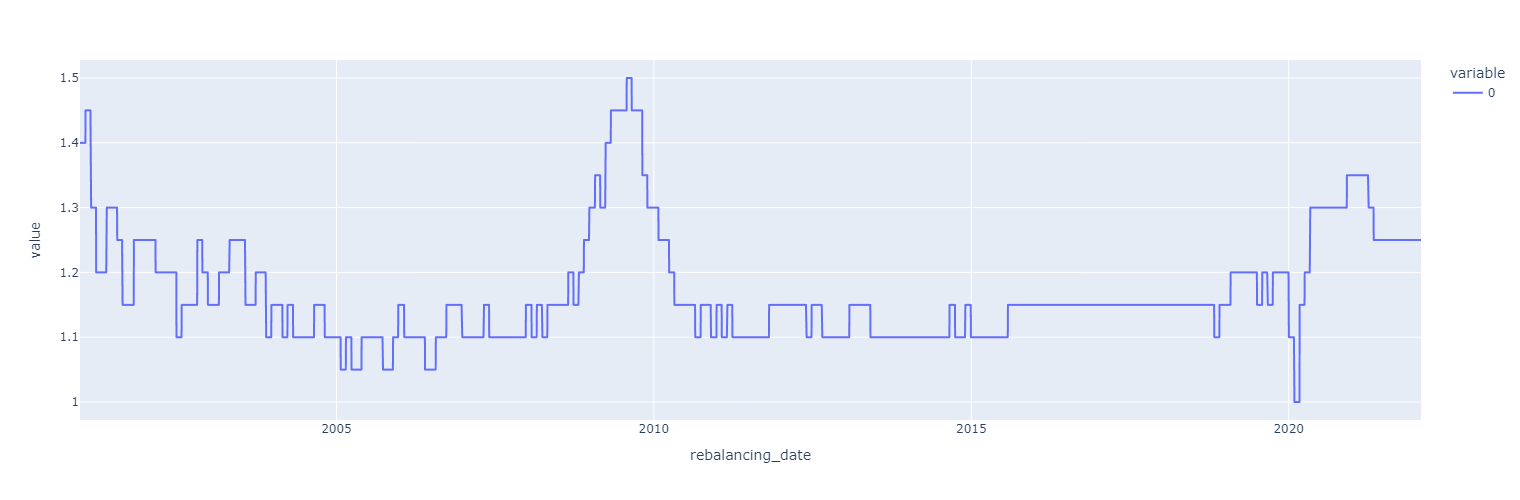

In [598]:
eval_model_outputs(res1, show_fig=True)

In [568]:
X.shape

(10353, 43)

### Try some different X (mainly with elastic net, as it works better, i.e., has "nicer" solutions)

In [600]:
params = {
    'pf_size' : pf_size,
    'opt_values_factors' : opt_values,
'include_ts_momentum_var_allstocks': True,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': True,
'include_iqr': True,
'include_factors': False,
'include_ewma_year': True,
'include_ewma_month': True,
'include_ew_year_vola': True,
'include_ew_month_vola': True,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': True,
    'additional_inputs' : [opt_v3]
}
X = re_hf.load_additional_train_data(**params)

In [228]:
%%capture
res1 = general_single_output_ElasticNet_Lagged(X, Y, len_train, single_train=False, expanding=False, train_size=len_train)

In [230]:
eval_model_outputs(res1, show_fig=False)

Result: (9.284, 10.354)


### Quick Hyperparameter Tuning with ElasticNet

In [620]:
elasticNet_params = {
    "alpha":[0.01, 0.1, 0.5, 1.0, 1.5],
    "l1_ratio":[0.1, 0.25, 0.5, 0.75, 0.9], 
    "fit_intercept":[True], 
    "precompute":[False], 
    "max_iter":[500,1000, 1500], 
    "copy_X":[True],
    "tol":[0.0001], 
    "warm_start":[False],
    "positive":[False], 
    "random_state":[123], 
    "selection":['cyclic']
    }

In [621]:
from sklearn.model_selection import ParameterSampler
param_list = list(ParameterSampler(elasticNet_params, n_iter=75, random_state=np.random.RandomState(83)))

Result: (9.289, 10.347)


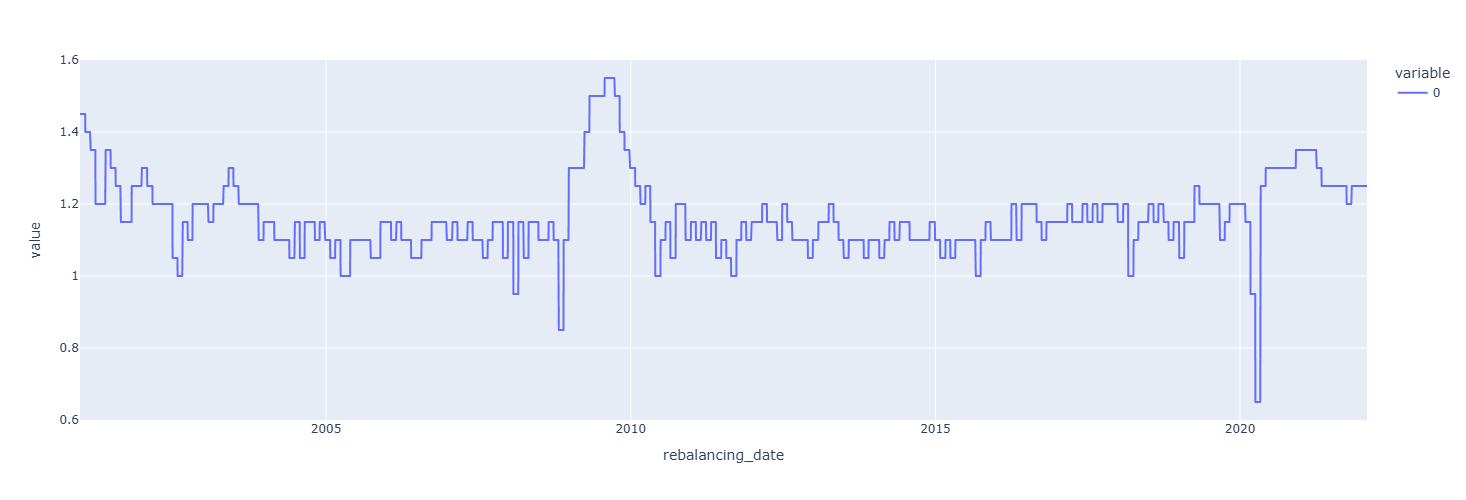

In [627]:
res1 = general_single_output_ElasticNet_Lagged(X, Y, len_train, single_train=False, expanding=False, train_size=len_train, model_params=param_list[33])
eval_model_outputs(res1, show_fig=True)

In [622]:
for i, p in enumerate(param_list):
    res1 = general_single_output_ElasticNet_Lagged(X, Y, len_train, single_train=False, expanding=False, train_size=len_train, model_params=p)
    print(f"Param {i}: ", eval_model_outputs(res1, show_fig=False))

Result: (9.313, 10.352)
Param 0:  None
Result: (9.313, 10.352)
Param 1:  None
Result: (9.313, 10.352)
Param 2:  None
Result: (9.317, 10.354)
Param 3:  None
Result: (9.317, 10.354)
Param 4:  None
Result: (9.317, 10.354)
Param 5:  None
Result: (9.314, 10.353)
Param 6:  None
Result: (9.314, 10.353)
Param 7:  None
Result: (9.314, 10.353)
Param 8:  None
Result: (9.307, 10.353)
Param 9:  None
Result: (9.307, 10.353)
Param 10:  None
Result: (9.307, 10.353)
Param 11:  None
Result: (9.306, 10.356)
Param 12:  None
Result: (9.306, 10.356)
Param 13:  None
Result: (9.306, 10.356)
Param 14:  None
Result: (9.29, 10.349)
Param 15:  None
Result: (9.29, 10.349)
Param 16:  None
Result: (9.29, 10.349)
Param 17:  None
Result: (9.292, 10.349)
Param 18:  None
Result: (9.292, 10.349)
Param 19:  None
Result: (9.292, 10.349)
Param 20:  None
Result: (9.293, 10.35)
Param 21:  None
Result: (9.293, 10.35)
Param 22:  None
Result: (9.293, 10.35)
Param 23:  None
Result: (9.289, 10.35)
Param 24:  None
Result: (9.289, 1

### Try out some other estimation methods

In [567]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

def general_single_output_model_Lagged(X, Y, len_train, single_train=False, expanding=False, train_size=None, model_params={}):
    model_predictions = []
    if train_size is None:
        train_size = len_train
    for i in range(X.shape[0] // 21):  # is too long which is why we have a if clause
        if len_train + 21*(i+1) > X.shape[0]:
            model_predictions = np.repeat(model_predictions, 21)
            return model_predictions
        else:  # TRAINING
            if single_train == False:
                if expanding == False:
                    x_train = X[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    #x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
                    y_train = Y[len_train - train_size + 21*i : len_train + 21*(i-1), ]
                    #y_train = (y_train - y_train.mean(axis=0)) / y_train.std(axis=0)
                else:
                    x_train = X[len_train - train_size : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size : len_train + 21*(i-1), ]
                regr = RandomForestRegressor(random_state=123, **model_params)
                regr = regr.fit(x_train, y_train)
            else:
                if i == 0:
                    x_train = X[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    #x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
                    y_train = Y[len_train - train_size + 21 * i: len_train + 21 * (i - 1), ]
                    #y_train = (y_train - y_train.mean(axis=0)) / y_train.std(axis=0)
                    regr = RandomForestRegressor(random_state=123, **model_params)
                    regr = regr.fit(x_train, y_train)
            ## TRAINING DONE
            # OLD: x_test = X[len_train + 21 * (i - 1):len_train + 21 * i, :]
            #x_test_mean = X[len_train + 21 * (i - 1):len_train + 21 * i, :].mean(axis=1)
            #x_test_sd = X[len_train + 21 * (i - 1):len_train + 21 * i, :].std(axis=1, ddof=1)
            
            x_test = np.ascontiguousarray(X[len_train + 21 * i, :].reshape(1, -1))
            #x_test = (x_test - x_train.mean(axis=0)) / x_train.std(axis=0)

            
            preds = regr.predict(x_test)
            preds = np.round(preds, 0)
            #preds = preds * y_train.std(axis=0) +  y_train.mean(axis=0)
            #preds = np.round(preds, 0)

            #print(f"fitted model in iteration {i} out of {5313//21}")
            model_predictions.append(preds)

In [565]:
res1 = general_single_output_model_Lagged(X, Y, len_train, single_train=False, expanding=False, train_size=len_train)
#eval_model_outputs(res1, show_fig=False)

Result: (9.449, 10.398)


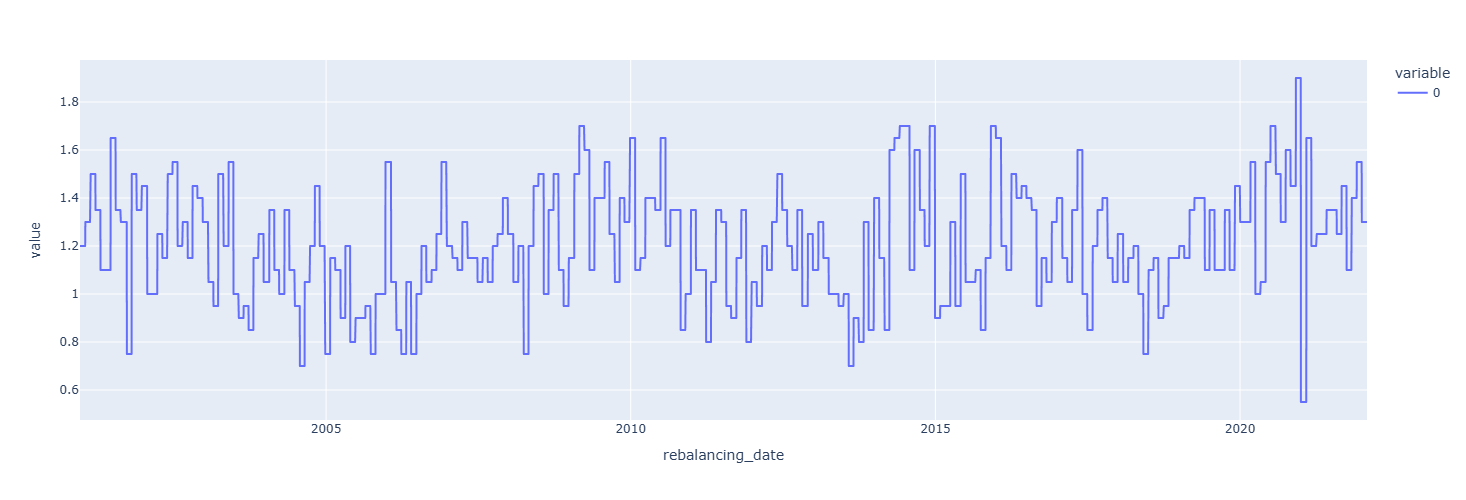

In [566]:
eval_model_outputs(res1, show_fig=True)

### Train MultiTask Model
#### Problem: for each intensity of intensity, we have an elastic net. This way it is very flexible, but we have no "structure" in the results whatsoever.

In [651]:
from sklearn.linear_model import MultiTaskElasticNet
def general_single_output_MultiTaskElasticNet_Lagged(X, Y, len_train, single_train=False, expanding=False, train_size=None):
    model_predictions = []
    if train_size is None:
        train_size = len_train
    for i in range(X.shape[0] // 21):  # is too long which is why we have a if clause
        if len_train + 21*(i+1) > X.shape[0]:
            model_predictions = np.repeat(model_predictions, 21)
            return model_predictions
        else:  # TRAINING
            if single_train == False:
                if expanding == False:
                    x_train = X[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    #x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
                    y_train = Y[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    #y_train = (y_train - y_train.mean(axis=0)) / y_train.std(axis=0)
                else:
                    x_train = X[len_train - train_size : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size : len_train + 21*(i-1), :]
                regr = MultiTaskElasticNet(random_state=123)
                regr = regr.fit(x_train, y_train)
            else:
                if i == 0:
                    x_train = X[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    #x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
                    y_train = Y[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    #y_train = (y_train - y_train.mean(axis=0)) / y_train.std(axis=0)
                    regr = MultiTaskElasticNet(random_state=123)
                    regr = regr.fit(x_train, y_train)
            ## TRAINING DONE
            x_test = X[len_train + 21 * (i - 1):len_train + 21 * i, :]
            x_test = np.ascontiguousarray(X[len_train + 21 * i, :].reshape(1, -1))
            #x_test = (x_test - x_train.mean(axis=0)) / x_train.std(axis=0)
            preds = regr.predict(x_test)

            #preds = int(np.round(preds, 0))

            if i%21 == 0:
                print(f"fitted model in iteration {i} out of {5313//21}")
            model_predictions.append(preds)

In [652]:
Y_multitask = all_res.copy()
Y_multitask = Y_multitask.drop([i for i in range(21)]).reset_index(drop=True)
Y_multitask = pd.concat([Y_multitask, all_res.copy().iloc[-21:]])
Y_multitask.iloc[-21:, :] = 10.0

In [653]:
#Y_multitask = all_res.copy()
#Y_multitask.iloc[0:21, :] = 7.0

params = {
    'pf_size' : pf_size,
    'opt_values_factors' : opt_values,
'include_ts_momentum_var_allstocks': True,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': True,
'include_iqr': True,
'include_factors': False,
'include_ewma_year': True,
'include_ewma_month': True,
'include_ew_year_vola': True,
'include_ew_month_vola': True,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': True,
    'additional_inputs' : [Y_multitask]
}
X = re_hf.load_additional_train_data(**params)

In [655]:
res1 = general_single_output_MultiTaskElasticNet_Lagged(X, all_res.copy().values, len_train, single_train=False, expanding=False, train_size=len_train)

fitted model in iteration 0 out of 253
fitted model in iteration 21 out of 253
fitted model in iteration 42 out of 253
fitted model in iteration 63 out of 253
fitted model in iteration 84 out of 253
fitted model in iteration 105 out of 253
fitted model in iteration 126 out of 253
fitted model in iteration 147 out of 253
fitted model in iteration 168 out of 253
fitted model in iteration 189 out of 253
fitted model in iteration 210 out of 253
fitted model in iteration 231 out of 253
fitted model in iteration 252 out of 253
